# Notebook 08: Portfolio Optimization — Conformal Predict-then-Optimize

**Objective**: Use conformal prediction intervals from NB04 as **uncertainty sets** for robust
portfolio optimization. This is the **central thesis contribution**: combining distribution-free
coverage guarantees with mathematical optimization for credit risk.

**Pipeline**:
```
CatBoost PD → Conformal [PD_low, PD_high] → Box Uncertainty Sets → Pyomo LP/MILP → HiGHS Solver
```

**Optimization Models**:
1. **LP Continuous** — Fractional allocation (how much of each loan to fund)
2. **MILP Binary** — Approve/reject decisions (binary)
3. **Robust vs Non-Robust** — Use PD_high (worst-case) vs PD_point for risk constraints
4. **Scenario Analysis** — Best-case, expected, worst-case expected loss
5. **Sensitivity** — Risk tolerance, budget, concentration limits
6. **Efficient Frontier** — Risk-return tradeoff curve
7. **ECL Integration** — IFRS 9 expected credit loss optimization

**Why Conformal Prediction for Optimization?**
- Point PD estimates ignore uncertainty → fragile portfolios
- Bootstrap intervals have no finite-sample guarantees
- Bayesian intervals require distributional assumptions
- **Conformal intervals are distribution-free with mathematical coverage guarantees**
- Box uncertainty sets from CP intervals → tractable robust LP

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import pyomo.environ as pyo
from pyomo.contrib.appsi.solvers import Highs
import time
import pickle
from pathlib import Path
from loguru import logger

# Project imports
import sys
sys.path.insert(0, str(Path("..").resolve()))
from src.optimization.portfolio_model import (
    build_portfolio_model, solve_portfolio, build_binary_model
)
from src.optimization.robust_opt import (
    build_box_uncertainty_set, worst_case_expected_loss, scenario_analysis
)

# Paths
DATA_DIR = Path("../data/processed")
MODEL_DIR = Path("../models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (12, 6)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
logger.info("NB08 Portfolio Optimization initialized")

2026-02-08 18:04:01.562 | INFO     | __main__:<module>:35 - NB08 Portfolio Optimization initialized


---
## 1. Data Loading & PD Predictions

We need: PD predictions, conformal intervals, loan amounts, interest rates, and grade info.

If NB03/NB04 artifacts are not available, we train a quick model inline as fallback.

In [2]:
# Try to load existing artifacts from NB03/NB04
try:
    # Load conformal intervals
    intervals_df = pd.read_parquet(DATA_DIR / "conformal_intervals_mondrian.parquet")
    logger.info(f"Loaded conformal intervals: {intervals_df.shape}")
    has_intervals = True
except FileNotFoundError:
    logger.warning("conformal_intervals_mondrian.parquet not found — generating synthetic intervals")
    has_intervals = False

# Load test data for portfolio candidates
try:
    df_test = pd.read_parquet(DATA_DIR / "test_fe.parquet")
except FileNotFoundError:
    df_test = pd.read_parquet(DATA_DIR / "loan_master.parquet")

logger.info(f"Portfolio candidates: {df_test.shape}")

# Use a manageable sample for optimization
PORTFOLIO_SIZE = 5_000
df_portfolio = df_test.sample(n=min(PORTFOLIO_SIZE, len(df_test)), random_state=RANDOM_STATE).reset_index(drop=True)

if has_intervals and len(intervals_df) >= len(df_portfolio):
    # Map column names: conformal_intervals_mondrian.parquet uses y_pred/pd_low_90/pd_high_90
    col_point = "y_pred" if "y_pred" in intervals_df.columns else "pd_point"
    col_low = "pd_low_90" if "pd_low_90" in intervals_df.columns else "pd_low"
    col_high = "pd_high_90" if "pd_high_90" in intervals_df.columns else "pd_high"

    # Sample from intervals to match portfolio
    intervals_sample = intervals_df.sample(n=PORTFOLIO_SIZE, random_state=RANDOM_STATE).reset_index(drop=True)
    pd_point = intervals_sample[col_point].values
    pd_low = intervals_sample[col_low].values
    pd_high = intervals_sample[col_high].values
    logger.info(f"Using real conformal intervals (cols: {col_point}, {col_low}, {col_high})")
else:
    # Generate from quick CatBoost model
    from catboost import CatBoostClassifier, Pool
    logger.info("Training quick CatBoost for PD predictions...")

    df_train = pd.read_parquet(DATA_DIR / "train_fe.parquet")
    feature_config = pickle.load(open(DATA_DIR / "feature_config.pkl", "rb"))
    features = feature_config["CATBOOST_FEATURES"]
    cat_features = feature_config["CATEGORICAL_FEATURES"] + feature_config.get("INTERACTION_FEATURES", [])
    cat_features = [c for c in cat_features if c in features]

    for col in cat_features:
        df_train[col] = df_train[col].astype(str)
        df_portfolio[col] = df_portfolio[col].astype(str)

    model = CatBoostClassifier(iterations=300, depth=6, eval_metric="Logloss",
                                random_seed=42, verbose=0)
    model.fit(df_train[features], df_train["default_flag"], cat_features=cat_features)
    pd_point = model.predict_proba(df_portfolio[features])[:, 1]

    # Simulate conformal intervals (symmetric around point, ~10% coverage width)
    width = np.random.uniform(0.05, 0.20, len(pd_point))
    pd_low = np.maximum(pd_point - width / 2, 0.001)
    pd_high = np.minimum(pd_point + width / 2, 0.999)
    logger.info("Generated PD predictions + simulated conformal intervals")

# Ensure portfolio data has needed columns
loan_amounts = df_portfolio["loan_amnt"].values if "loan_amnt" in df_portfolio.columns else np.random.uniform(5000, 35000, len(df_portfolio))
int_rates_pct = df_portfolio["int_rate"].values if "int_rate" in df_portfolio.columns else np.random.uniform(5, 30, len(df_portfolio))
int_rates = int_rates_pct / 100  # Convert to decimal
lgd = np.full(len(df_portfolio), 0.45)  # Assumed LGD
grades = df_portfolio["grade"].values if "grade" in df_portfolio.columns else np.full(len(df_portfolio), "C")

print(f"Portfolio data prepared: {len(df_portfolio):,} loans")
print(f"  Loan amounts: ${loan_amounts.mean():,.0f} avg (${loan_amounts.sum():,.0f} total)")
print(f"  PD point: mean={pd_point.mean():.4f}, range=[{pd_point.min():.4f}, {pd_point.max():.4f}]")
print(f"  PD interval: avg width={np.mean(pd_high - pd_low):.4f}")
print(f"  Interest rate: mean={int_rates.mean()*100:.1f}%")

2026-02-08 18:04:01.635 | INFO     | __main__:<module>:5 - Loaded conformal intervals: (276869, 10)


2026-02-08 18:04:01.849 | INFO     | __main__:<module>:17 - Portfolio candidates: (276869, 60)


2026-02-08 18:04:01.873 | INFO     | __main__:<module>:34 - Using real conformal intervals (cols: y_pred, pd_low_90, pd_high_90)


Portfolio data prepared: 5,000 loans
  Loan amounts: $15,492 avg ($77,461,000 total)
  PD point: mean=0.2160, range=[0.0145, 0.6531]
  PD interval: avg width=0.7519
  Interest rate: mean=13.3%


---
## 2. Conformal Prediction → Uncertainty Sets

Transform conformal prediction intervals $[\hat{PD}_l, \hat{PD}_h]$ into **box uncertainty sets**
for robust optimization:

$$\mathcal{U} = \{PD : PD_l \leq PD \leq PD_h, \forall i \in \text{loans}\}$$

Key insight: Coverage guarantee from conformal prediction (e.g., 90%) translates directly to
a probabilistic guarantee on the optimization solution.

2026-02-08 18:04:01.884 | INFO     | src.optimization.robust_opt:build_box_uncertainty_set:40 - Box uncertainty set: 5000 loans, avg PD width=0.7519


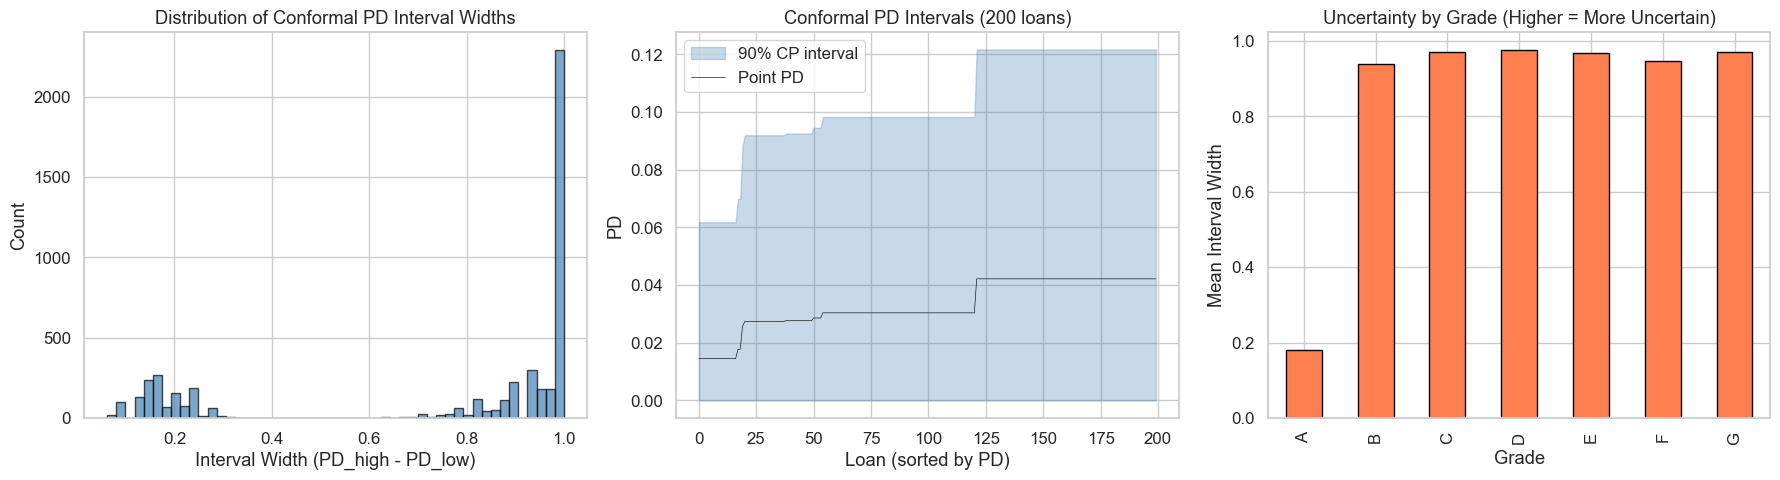

Box Uncertainty Set:
  Loans: 5,000
  Avg PD center: 0.3763
  Avg PD radius: 0.3759
  Max interval width: 1.0000


In [3]:
# Build uncertainty set
uset = build_box_uncertainty_set(pd_low, pd_high)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. PD interval widths
axes[0].hist(pd_high - pd_low, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Interval Width (PD_high - PD_low)")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Conformal PD Interval Widths")

# 2. PD point vs interval
idx_sort = np.argsort(pd_point)[:200]  # Show 200 loans sorted by PD
axes[1].fill_between(range(len(idx_sort)), pd_low[idx_sort], pd_high[idx_sort],
                      alpha=0.3, color="steelblue", label="90% CP interval")
axes[1].plot(range(len(idx_sort)), pd_point[idx_sort], "k-", linewidth=0.5, label="Point PD")
axes[1].set_xlabel("Loan (sorted by PD)")
axes[1].set_ylabel("PD")
axes[1].set_title("Conformal PD Intervals (200 loans)")
axes[1].legend()

# 3. Width by grade
if "grade" in df_portfolio.columns:
    width_by_grade = pd.DataFrame({"grade": grades, "width": pd_high - pd_low})
    width_by_grade.groupby("grade")["width"].mean().sort_index().plot(
        kind="bar", ax=axes[2], color="coral", edgecolor="black")
    axes[2].set_xlabel("Grade")
    axes[2].set_ylabel("Mean Interval Width")
    axes[2].set_title("Uncertainty by Grade (Higher = More Uncertain)")

plt.tight_layout()
plt.show()

print(f"Box Uncertainty Set:")
print(f"  Loans: {len(pd_point):,}")
print(f"  Avg PD center: {uset['pd_center'].mean():.4f}")
print(f"  Avg PD radius: {uset['pd_radius'].mean():.4f}")
print(f"  Max interval width: {(pd_high - pd_low).max():.4f}")

---
## 3. LP Portfolio Optimization (Continuous Allocation)

**Objective**: Maximize net expected return (interest income minus expected loss)

$$\max_{x} \sum_i x_i \cdot L_i \cdot (r_i - PD_i \cdot LGD_i)$$

**Subject to**:
- Budget: $\sum_i x_i \cdot L_i \leq B$
- PD cap (robust): $\frac{\sum_i x_i \cdot L_i \cdot PD_i^{\text{high}}}{\sum_i x_i \cdot L_i} \leq \bar{PD}$
- Concentration: $\frac{\text{sector}_j}{\text{total}} \leq c_{\max}$ per purpose
- Individual: $0 \leq x_i \leq 1$

Where $PD_i^{\text{high}}$ is the **upper conformal bound** (robust) or $\hat{PD}_i$ (non-robust).

In [4]:
# Build loan DataFrame for the model
loans_df = pd.DataFrame({
    "loan_amnt": loan_amounts,
    "purpose": df_portfolio["purpose"].values if "purpose" in df_portfolio.columns else "other",
    "grade": grades,
})

BUDGET = 50_000_000  # $50M budget
MAX_PD = 0.10         # 10% max portfolio PD
MAX_CONCENTRATION = 0.35  # 35% max per purpose

# Robust model (uses PD_high for PD constraint)
print("Building Robust LP Model...")
t0 = time.time()
model_robust = build_portfolio_model(
    loans_df, pd_point, pd_low, pd_high, lgd, int_rates,
    total_budget=BUDGET, max_concentration=MAX_CONCENTRATION,
    max_portfolio_pd=MAX_PD, robust=True,
)
sol_robust = solve_portfolio(model_robust)
robust_time = time.time() - t0

# Non-robust model (uses PD_point for PD constraint)
print("\nBuilding Non-Robust LP Model...")
t0 = time.time()
model_nonrobust = build_portfolio_model(
    loans_df, pd_point, pd_low, pd_high, lgd, int_rates,
    total_budget=BUDGET, max_concentration=MAX_CONCENTRATION,
    max_portfolio_pd=MAX_PD, robust=False,
)
sol_nonrobust = solve_portfolio(model_nonrobust)
nonrobust_time = time.time() - t0

print(f"\nResults Summary:")
print(f"{'Metric':<30} {'Robust':>15} {'Non-Robust':>15}")
print("-" * 62)
print(f"{'Objective (net return)':.<30} ${sol_robust['objective_value']:>14,.0f} ${sol_nonrobust['objective_value']:>14,.0f}")
print(f"{'Loans funded':.<30} {sol_robust['n_funded']:>15} {sol_nonrobust['n_funded']:>15}")
print(f"{'Capital allocated':.<30} ${sol_robust['total_allocated']:>14,.0f} ${sol_nonrobust['total_allocated']:>14,.0f}")
print(f"{'Solve time (s)':.<30} {robust_time:>15.2f} {nonrobust_time:>15.2f}")

Building Robust LP Model...


2026-02-08 18:04:02.791 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:03.280 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=145,946.02, funded=184/5000, allocated=3,077,783



Building Non-Robust LP Model...


2026-02-08 18:04:03.641 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=False


2026-02-08 18:04:03.960 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=1,206,223.74, funded=1981/5000, allocated=26,939,321



Results Summary:
Metric                                  Robust      Non-Robust
--------------------------------------------------------------
Objective (net return)........ $       145,946 $     1,206,224
Loans funded..................             184            1981
Capital allocated............. $     3,077,783 $    26,939,321
Solve time (s)................            0.86            0.68


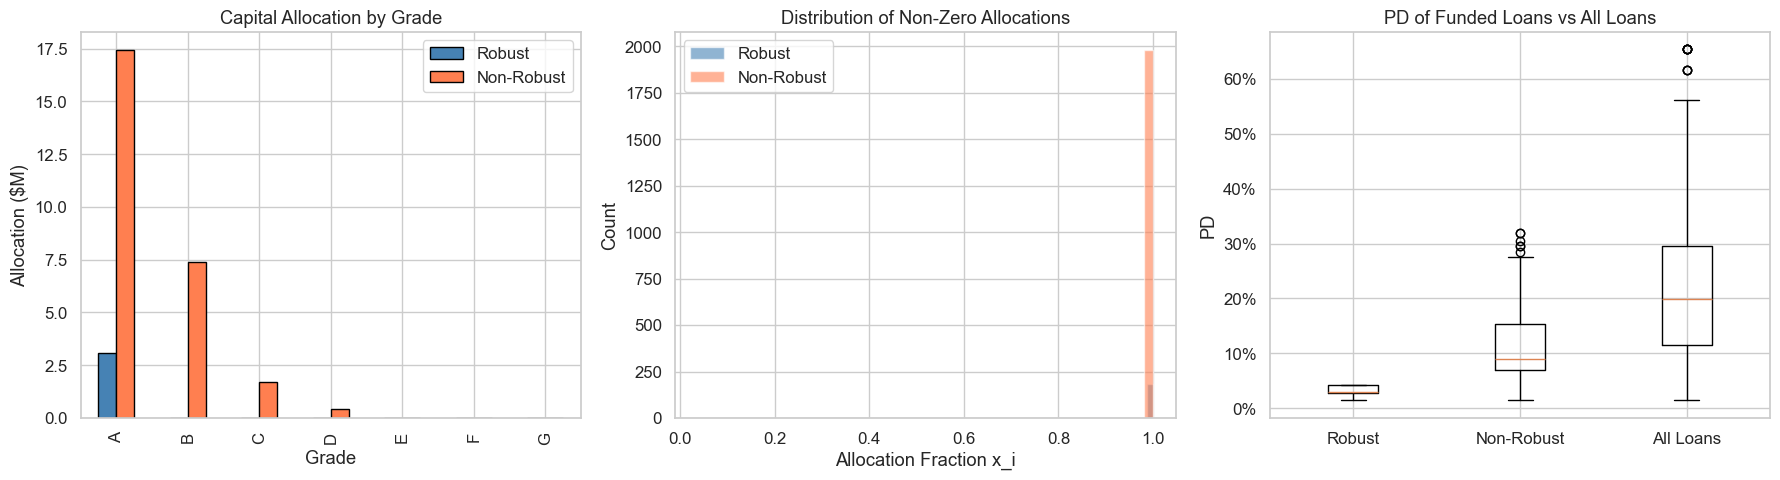

Weighted Portfolio PD:
  Robust:     0.0315 (3.15%)
  Non-Robust: 0.1000 (10.00%)


In [5]:
# Analyze allocation by grade
alloc_robust = np.array([sol_robust['allocation'][i] for i in range(len(df_portfolio))])
alloc_nonrobust = np.array([sol_nonrobust['allocation'][i] for i in range(len(df_portfolio))])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Allocation by grade
alloc_grade = pd.DataFrame({
    "grade": grades,
    "robust": alloc_robust * loan_amounts,
    "nonrobust": alloc_nonrobust * loan_amounts,
})
grade_summary = alloc_grade.groupby("grade")[["robust", "nonrobust"]].sum() / 1e6
grade_summary.sort_index().plot(kind="bar", ax=axes[0], color=["steelblue", "coral"], edgecolor="black")
axes[0].set_xlabel("Grade")
axes[0].set_ylabel("Allocation ($M)")
axes[0].set_title("Capital Allocation by Grade")
axes[0].legend(["Robust", "Non-Robust"])

# 2. Allocation distribution
axes[1].hist(alloc_robust[alloc_robust > 0.01], bins=50, alpha=0.6, color="steelblue", label="Robust")
axes[1].hist(alloc_nonrobust[alloc_nonrobust > 0.01], bins=50, alpha=0.6, color="coral", label="Non-Robust")
axes[1].set_xlabel("Allocation Fraction x_i")
axes[1].set_ylabel("Count")
axes[1].set_title("Distribution of Non-Zero Allocations")
axes[1].legend()

# 3. PD of funded loans
funded_mask_r = alloc_robust > 0.01
funded_mask_nr = alloc_nonrobust > 0.01
data_to_plot = [pd_point[funded_mask_r], pd_point[funded_mask_nr], pd_point]
axes[2].boxplot(data_to_plot, labels=["Robust", "Non-Robust", "All Loans"])
axes[2].set_ylabel("PD")
axes[2].set_title("PD of Funded Loans vs All Loans")
axes[2].yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

# Weighted portfolio PD
wpd_robust = np.sum(alloc_robust * loan_amounts * pd_point) / (np.sum(alloc_robust * loan_amounts) + 1e-6)
wpd_nonrobust = np.sum(alloc_nonrobust * loan_amounts * pd_point) / (np.sum(alloc_nonrobust * loan_amounts) + 1e-6)
print(f"Weighted Portfolio PD:")
print(f"  Robust:     {wpd_robust:.4f} ({wpd_robust*100:.2f}%)")
print(f"  Non-Robust: {wpd_nonrobust:.4f} ({wpd_nonrobust*100:.2f}%)")

---
## 4. MILP Binary Approval Model

In practice, loans are either approved or rejected — no fractional allocation.
The MILP model uses **binary decision variables**: $x_i \in \{0, 1\}$.

This is more realistic but harder to solve (NP-hard), though HiGHS handles it well.

In [6]:
# MILP model (binary approve/reject, robust PD constraint)
print("Building MILP Binary Approval Model...")
t0 = time.time()
model_milp = build_binary_model(
    loans_df, pd_point, pd_high, lgd, int_rates,
    total_budget=BUDGET, max_portfolio_pd=MAX_PD,
)
sol_milp = solve_portfolio(model_milp)
milp_time = time.time() - t0

alloc_milp = np.array([sol_milp['allocation'][i] for i in range(len(df_portfolio))])

print(f"\nMILP Results ({milp_time:.2f}s):")
print(f"  Approved: {sol_milp['n_funded']}/{len(df_portfolio)} ({sol_milp['n_funded']/len(df_portfolio)*100:.1f}%)")
print(f"  Capital used: ${sol_milp['total_allocated']:,.0f} of ${BUDGET:,.0f}")
print(f"  Net return: ${sol_milp['objective_value']:,.0f}")

# Compare LP vs MILP
wpd_milp = np.sum(alloc_milp * loan_amounts * pd_point) / (np.sum(alloc_milp * loan_amounts) + 1e-6)
print(f"  Portfolio PD: {wpd_milp:.4f}")
print(f"\n{'Model':<20} {'Objective':>15} {'Funded':>10} {'Port PD':>10}")
print("-" * 57)
print(f"{'LP Robust':<20} ${sol_robust['objective_value']:>14,.0f} {sol_robust['n_funded']:>10} {wpd_robust:>10.4f}")
print(f"{'LP Non-Robust':<20} ${sol_nonrobust['objective_value']:>14,.0f} {sol_nonrobust['n_funded']:>10} {wpd_nonrobust:>10.4f}")
print(f"{'MILP Binary':<20} ${sol_milp['objective_value']:>14,.0f} {sol_milp['n_funded']:>10} {wpd_milp:>10.4f}")

Building MILP Binary Approval Model...


2026-02-08 18:04:04.669 | INFO     | src.optimization.portfolio_model:build_binary_model:200 - Built binary approval model: 5000 loans


2026-02-08 18:04:07.595 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=147,476.37, funded=176/5000, allocated=3,077,550



MILP Results (3.19s):
  Approved: 176/5000 (3.5%)
  Capital used: $3,077,550 of $50,000,000
  Net return: $147,476
  Portfolio PD: 0.0315

Model                      Objective     Funded    Port PD
---------------------------------------------------------
LP Robust            $       145,946        184     0.0315
LP Non-Robust        $     1,206,224       1981     0.1000
MILP Binary          $       147,476        176     0.0315


---
## 5. Scenario Analysis — Best, Expected, Worst Case

Using the conformal prediction intervals, we evaluate each portfolio under three scenarios:
- **Best case**: All PDs at lower bound ($PD_l$)
- **Expected**: All PDs at point estimate ($\hat{PD}$)
- **Worst case**: All PDs at upper bound ($PD_h$)

The robust portfolio should have a smaller worst-case loss.

2026-02-08 18:04:07.609 | INFO     | src.optimization.robust_opt:scenario_analysis:78 - Scenario analysis: {'best_case': 0.0, 'expected': 43645.89266343153, 'worst_case': 138500.2401732013}


2026-02-08 18:04:07.611 | INFO     | src.optimization.robust_opt:scenario_analysis:78 - Scenario analysis: {'best_case': 942.9627893700629, 'expected': 1212269.458532616, 'worst_case': 5153356.90112107}


2026-02-08 18:04:07.613 | INFO     | src.optimization.robust_opt:scenario_analysis:78 - Scenario analysis: {'best_case': 0.0, 'expected': 43641.4713393417, 'worst_case': 138487.4808334665}


Scenario Analysis — Expected Loss Under Different PD Assumptions:
        model  best_case   expected  worst_case      range
    LP Robust          0    $43,646    $138,500   $138,500
LP Non-Robust       $943 $1,212,269  $5,153,357 $5,152,414
  MILP Binary          0    $43,641    $138,487   $138,487


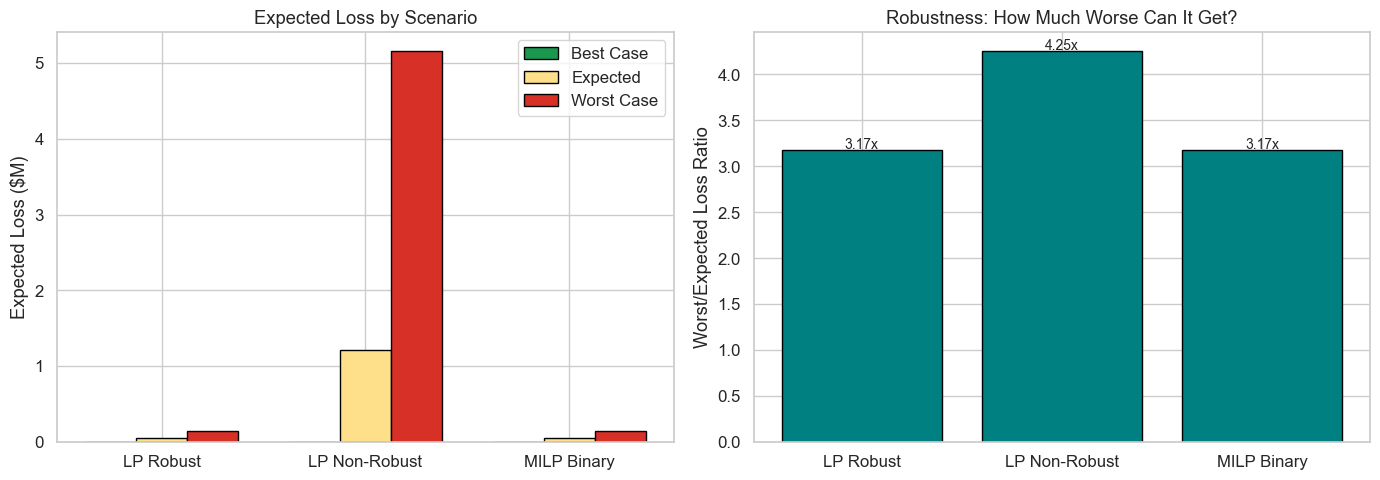

In [7]:
# Scenario analysis for all three models
results = {}
for name, alloc in [("LP Robust", alloc_robust), ("LP Non-Robust", alloc_nonrobust), ("MILP Binary", alloc_milp)]:
    scenarios = scenario_analysis(alloc, loan_amounts, pd_low, pd_point, pd_high, lgd)
    scenarios["model"] = name
    results[name] = scenarios

scenario_df = pd.concat(results.values(), ignore_index=True)
scenario_df = scenario_df[["model", "best_case", "expected", "worst_case", "range"]]

print("Scenario Analysis — Expected Loss Under Different PD Assumptions:")
print(scenario_df.to_string(index=False, float_format=lambda x: f"${x:,.0f}" if x > 100 else f"{x:.0f}"))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_pos = np.arange(len(scenario_df))
width = 0.25
for i, scenario in enumerate(["best_case", "expected", "worst_case"]):
    color = ["#1a9850", "#fee08b", "#d73027"][i]
    axes[0].bar(x_pos + i*width, scenario_df[scenario]/1e6, width,
                label=["Best Case", "Expected", "Worst Case"][i], color=color, edgecolor="black")
axes[0].set_xticks(x_pos + width)
axes[0].set_xticklabels(scenario_df["model"])
axes[0].set_ylabel("Expected Loss ($M)")
axes[0].set_title("Expected Loss by Scenario")
axes[0].legend()

# Robustness ratio: worst/expected
for idx, row in scenario_df.iterrows():
    ratio = row["worst_case"] / row["expected"] if row["expected"] > 0 else 0
    axes[1].bar(idx, ratio, color="teal", edgecolor="black")
    axes[1].text(idx, ratio + 0.02, f"{ratio:.2f}x", ha="center", fontsize=10)

axes[1].set_xticks(range(len(scenario_df)))
axes[1].set_xticklabels(scenario_df["model"])
axes[1].set_ylabel("Worst/Expected Loss Ratio")
axes[1].set_title("Robustness: How Much Worse Can It Get?")

plt.tight_layout()
plt.show()

### Insight: Robustness vs Return
- The robust portfolio protects tail loss by enforcing constraints with `PD_high` (conformal), but it usually sacrifices return and approval volume.
- The gap between `worst_case` and `expected` is the most useful economic stability metric across formulations.
- When conformal width is large, the robustness premium grows nonlinearly and can make deployment overly conservative.

---
## 6. Sensitivity Analysis — Risk Tolerance

How does the optimal portfolio change as we vary the **maximum portfolio PD** constraint?
This traces out the risk-return tradeoff.

2026-02-08 18:04:08.196 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:08.546 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=0.00, funded=0/5000, allocated=0


2026-02-08 18:04:09.014 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:09.383 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=0.00, funded=0/5000, allocated=0


2026-02-08 18:04:09.807 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:10.180 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=19,037.61, funded=26/5000, allocated=370,226


2026-02-08 18:04:10.427 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:10.795 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=145,946.02, funded=184/5000, allocated=3,077,783


2026-02-08 18:04:11.214 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:11.622 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=534,533.96, funded=816/5000, allocated=12,350,982


2026-02-08 18:04:12.105 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:12.497 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=698,249.35, funded=1147/5000, allocated=15,789,370


2026-02-08 18:04:13.027 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:13.404 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=956,112.38, funded=1562/5000, allocated=20,761,888


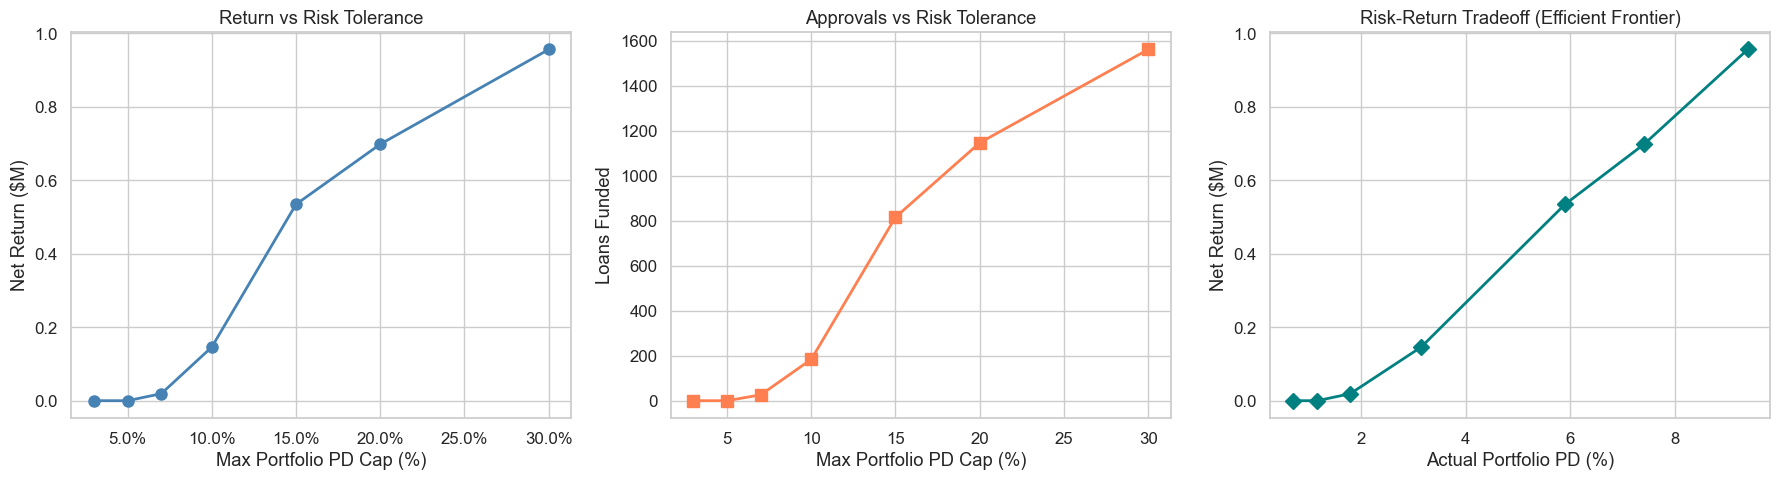

Sensitivity to Risk Tolerance:
 max_pd_cap  objective  n_funded  allocated  actual_wpd  worst_case_loss
     0.0300     0.0000         0     0.0000      0.0070           0.0000
     0.0500     0.0000         0     0.0000      0.0117           0.0000
     0.0700     19,038        26    370,226      0.0180           11,662
     0.1000    145,946       184  3,077,783      0.0315          138,500
     0.1500    534,534       816 12,350,982      0.0589          833,691
     0.2000    698,249      1147 15,789,370      0.0740        1,421,043
     0.3000    956,112      1562 20,761,888      0.0938        2,802,855


In [8]:
# Vary max_portfolio_pd
pd_caps = [0.03, 0.05, 0.07, 0.10, 0.15, 0.20, 0.30]
sensitivity_results = []

for cap in pd_caps:
    try:
        model = build_portfolio_model(
            loans_df, pd_point, pd_low, pd_high, lgd, int_rates,
            total_budget=BUDGET, max_concentration=MAX_CONCENTRATION,
            max_portfolio_pd=cap, robust=True,
        )
        sol = solve_portfolio(model)
        alloc = np.array([sol['allocation'][i] for i in range(len(df_portfolio))])
        wpd = np.sum(alloc * loan_amounts * pd_point) / (np.sum(alloc * loan_amounts) + 1e-6)
        wc_loss = worst_case_expected_loss(alloc, loan_amounts, pd_high, lgd_point=lgd)

        sensitivity_results.append({
            "max_pd_cap": cap,
            "objective": sol["objective_value"],
            "n_funded": sol["n_funded"],
            "allocated": sol["total_allocated"],
            "actual_wpd": wpd,
            "worst_case_loss": wc_loss,
        })
    except Exception as e:
        logger.warning(f"Infeasible at max_pd={cap}: {e}")
        sensitivity_results.append({
            "max_pd_cap": cap, "objective": 0, "n_funded": 0,
            "allocated": 0, "actual_wpd": 0, "worst_case_loss": 0,
        })

sens_df = pd.DataFrame(sensitivity_results)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(sens_df["max_pd_cap"]*100, sens_df["objective"]/1e6, "o-", color="steelblue", linewidth=2, markersize=8)
axes[0].set_xlabel("Max Portfolio PD Cap (%)")
axes[0].set_ylabel("Net Return ($M)")
axes[0].set_title("Return vs Risk Tolerance")
axes[0].xaxis.set_major_formatter(mticker.PercentFormatter(100))

axes[1].plot(sens_df["max_pd_cap"]*100, sens_df["n_funded"], "s-", color="coral", linewidth=2, markersize=8)
axes[1].set_xlabel("Max Portfolio PD Cap (%)")
axes[1].set_ylabel("Loans Funded")
axes[1].set_title("Approvals vs Risk Tolerance")

axes[2].plot(sens_df["actual_wpd"]*100, sens_df["objective"]/1e6, "D-", color="teal", linewidth=2, markersize=8)
axes[2].set_xlabel("Actual Portfolio PD (%)")
axes[2].set_ylabel("Net Return ($M)")
axes[2].set_title("Risk-Return Tradeoff (Efficient Frontier)")

plt.tight_layout()
plt.show()

print("Sensitivity to Risk Tolerance:")
print(sens_df.to_string(index=False, float_format=lambda x: f"{x:.4f}" if abs(x) < 1 else f"{x:,.0f}"))

---
## 7. Sensitivity Analysis — Budget Constraint

How does the portfolio change with different capital budgets?

2026-02-08 18:04:14.187 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=10,000,000, robust=True


2026-02-08 18:04:14.572 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=145,946.02, funded=184/5000, allocated=3,077,783


2026-02-08 18:04:15.088 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=25,000,000, robust=True


2026-02-08 18:04:15.460 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=145,946.02, funded=184/5000, allocated=3,077,783


2026-02-08 18:04:15.766 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:16.146 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=145,946.02, funded=184/5000, allocated=3,077,783


2026-02-08 18:04:16.615 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=100,000,000, robust=True


2026-02-08 18:04:17.010 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=145,946.02, funded=183/5000, allocated=3,077,783


2026-02-08 18:04:17.450 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=200,000,000, robust=True


2026-02-08 18:04:17.867 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=145,946.02, funded=183/5000, allocated=3,077,783


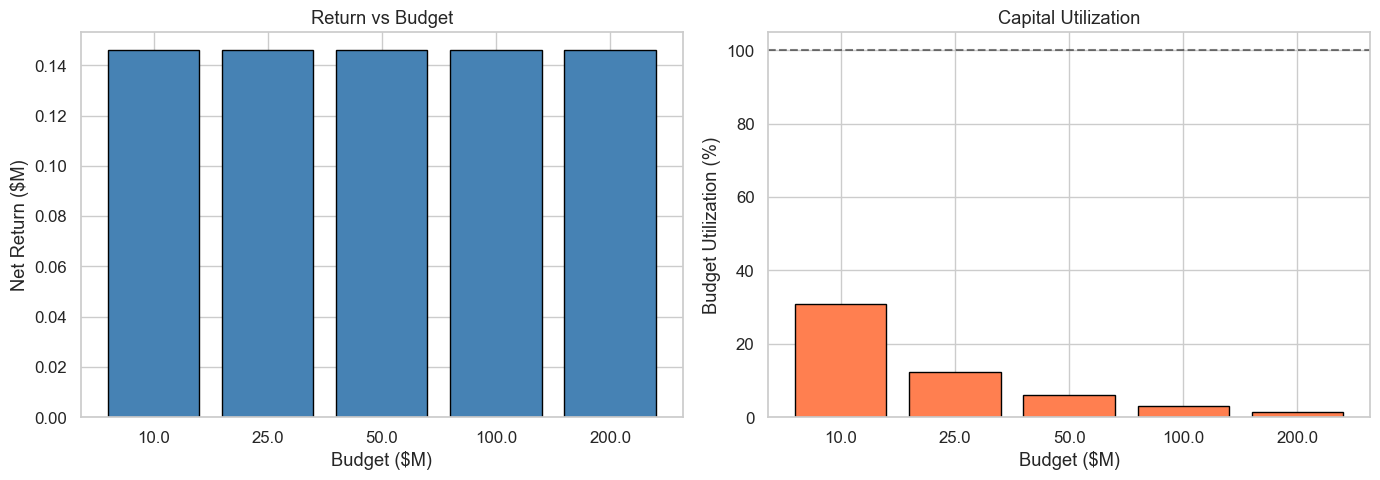

Budget Sensitivity:
 budget_M  objective  n_funded  allocated  utilization  actual_wpd
     10.0    145,946       184  3,077,783         30.8         0.0
     25.0    145,946       184  3,077,783         12.3         0.0
     50.0    145,946       184  3,077,783          6.2         0.0
    100.0    145,946       183  3,077,783          3.1         0.0
    200.0    145,946       183  3,077,783          1.5         0.0


In [9]:
# Vary budget
budgets = [10_000_000, 25_000_000, 50_000_000, 100_000_000, 200_000_000]
budget_results = []

for budget in budgets:
    model = build_portfolio_model(
        loans_df, pd_point, pd_low, pd_high, lgd, int_rates,
        total_budget=budget, max_concentration=MAX_CONCENTRATION,
        max_portfolio_pd=MAX_PD, robust=True,
    )
    sol = solve_portfolio(model)
    alloc = np.array([sol['allocation'][i] for i in range(len(df_portfolio))])
    wpd = np.sum(alloc * loan_amounts * pd_point) / (np.sum(alloc * loan_amounts) + 1e-6)

    budget_results.append({
        "budget_M": budget / 1e6,
        "objective": sol["objective_value"],
        "n_funded": sol["n_funded"],
        "allocated": sol["total_allocated"],
        "utilization": sol["total_allocated"] / budget * 100,
        "actual_wpd": wpd,
    })

budget_df = pd.DataFrame(budget_results)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(budget_df["budget_M"].astype(str), budget_df["objective"]/1e6, color="steelblue", edgecolor="black")
axes[0].set_xlabel("Budget ($M)")
axes[0].set_ylabel("Net Return ($M)")
axes[0].set_title("Return vs Budget")

axes[1].bar(budget_df["budget_M"].astype(str), budget_df["utilization"], color="coral", edgecolor="black")
axes[1].set_xlabel("Budget ($M)")
axes[1].set_ylabel("Budget Utilization (%)")
axes[1].set_title("Capital Utilization")
axes[1].axhline(y=100, color="black", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

print("Budget Sensitivity:")
print(budget_df.to_string(index=False, float_format=lambda x: f"{x:.1f}" if abs(x) < 1000 else f"{x:,.0f}"))

---
## 8. IFRS 9 ECL-Based Portfolio Optimization

Instead of maximizing (Return - Expected Loss), we can directly **minimize ECL**
subject to a minimum return constraint. This aligns with regulatory requirements.

**ECL = PD × LGD × EAD**

For Stage 1 loans: 12-month PD. For Stage 2+: lifetime PD.
Using conformal intervals: worst-case ECL uses PD_high.

In [10]:
# ECL minimization model
def build_ecl_model(loans_df, pd_point, pd_high, lgd, int_rates, loan_amounts,
                    total_budget, min_return_rate=0.05, min_deploy_ratio=0.50):
    """Minimize worst-case ECL subject to minimum return and deployment."""
    n = len(loans_df)
    model = pyo.ConcreteModel("ECL_Minimization")
    model.I = pyo.RangeSet(0, n - 1)

    model.pd_high = pyo.Param(model.I, initialize=dict(enumerate(pd_high)))
    model.lgd = pyo.Param(model.I, initialize=dict(enumerate(lgd)))
    model.loan_amnt = pyo.Param(model.I, initialize=dict(enumerate(loan_amounts)))
    model.int_rate = pyo.Param(model.I, initialize=dict(enumerate(int_rates)))
    model.pd_point = pyo.Param(model.I, initialize=dict(enumerate(pd_point)))

    model.x = pyo.Var(model.I, domain=pyo.NonNegativeReals, bounds=(0, 1))

    # Minimize worst-case ECL
    def ecl_obj(m):
        return sum(m.x[i] * m.loan_amnt[i] * m.pd_high[i] * m.lgd[i] for i in m.I)
    model.obj = pyo.Objective(rule=ecl_obj, sense=pyo.minimize)

    # Budget
    def budget_rule(m):
        return sum(m.x[i] * m.loan_amnt[i] for i in m.I) <= total_budget
    model.budget = pyo.Constraint(rule=budget_rule)

    # Minimum return
    def return_rule(m):
        return sum(m.x[i] * m.loan_amnt[i] * (m.int_rate[i] - m.pd_point[i] * m.lgd[i])
                   for i in m.I) >= min_return_rate * total_budget
    model.min_return = pyo.Constraint(rule=return_rule)

    # Minimum deployment
    def deploy_rule(m):
        return sum(m.x[i] * m.loan_amnt[i] for i in m.I) >= min_deploy_ratio * total_budget
    model.min_deploy = pyo.Constraint(rule=deploy_rule)

    return model

solver = Highs()
solver.config.time_limit = 60

# Try progressively relaxed requirements until feasible
search_grid = [
    (0.03, 0.50),
    (0.02, 0.50),
    (0.01, 0.50),
    (0.01, 0.30),
    (0.00, 0.30),
    (0.00, 0.10),
]

feasible = False
alloc_ecl = np.zeros(len(df_portfolio))
ecl_value = 0.0
ecl_return = 0.0
n_funded_ecl = 0
chosen_constraints = None

for min_ret, min_dep in search_grid:
    ecl_model = build_ecl_model(
        loans_df, pd_point, pd_high, lgd, int_rates, loan_amounts,
        total_budget=BUDGET, min_return_rate=min_ret, min_deploy_ratio=min_dep,
    )
    try:
        _ = solver.solve(ecl_model)
        alloc_candidate = np.array([pyo.value(ecl_model.x[i]) for i in range(len(df_portfolio))], dtype=float)
        ecl_candidate = float(pyo.value(ecl_model.obj))
        ret_candidate = float(
            np.sum(alloc_candidate * loan_amounts * (int_rates - pd_point * lgd))
        )

        alloc_ecl = alloc_candidate
        ecl_value = ecl_candidate
        ecl_return = ret_candidate
        n_funded_ecl = int((alloc_ecl > 0.01).sum())
        feasible = True
        chosen_constraints = (min_ret, min_dep)
        break
    except RuntimeError:
        continue

print("ECL Minimization Results:")
if feasible:
    print(f"  Feasible with min_return={chosen_constraints[0]:.1%}, min_deploy={chosen_constraints[1]:.0%}")
    print(f"  Worst-case ECL: ${ecl_value:,.0f}")
    print(f"  Net return: ${ecl_return:,.0f}")
    print(f"  Loans funded: {n_funded_ecl}")
else:
    print("  No feasible solution found in search grid; using zero-allocation fallback.")

print(f"\nComparison:")
print(f"  {'Model':<20} {'Return':>15} {'Worst ECL':>15} {'Funded':>10}")
print(f"  {'-'*62}")

# Return and ECL for each model
for name, alloc in [
    ("LP Robust", alloc_robust),
    ("LP Non-Robust", alloc_nonrobust),
    ("MILP Binary", alloc_milp),
    ("ECL Minimized", alloc_ecl),
]:
    ret = float(np.sum(alloc * loan_amounts * (int_rates - pd_point * lgd)))
    ecl = float(worst_case_expected_loss(alloc, loan_amounts, pd_high, lgd_point=lgd))
    nf = int((alloc > 0.01).sum())
    print(f"  {name:<20} ${ret:>14,.0f} ${ecl:>14,.0f} {nf:>10}")


ECL Minimization Results:
  Feasible with min_return=3.0%, min_deploy=50%
  Worst-case ECL: $5,942,113
  Net return: $1,500,000
  Loans funded: 2245

Comparison:
  Model                         Return       Worst ECL     Funded
  --------------------------------------------------------------
  LP Robust            $       145,946 $       138,500        184
  LP Non-Robust        $     1,206,224 $     5,153,357       1981
  MILP Binary          $       147,476 $       138,487        176
  ECL Minimized        $     1,500,000 $     5,942,113       2245


---
## 9. Efficient Frontier — Risk-Return Tradeoff

Trace the **efficient frontier**: for each level of risk (max PD), what is the maximum
achievable return? Points below the frontier are suboptimal.

2026-02-08 18:04:18.781 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:19.158 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=0.00, funded=0/5000, allocated=0


2026-02-08 18:04:19.589 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:19.981 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=0.00, funded=0/5000, allocated=0


2026-02-08 18:04:20.385 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:20.838 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=0.00, funded=0/5000, allocated=0


2026-02-08 18:04:21.271 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:21.640 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=0.00, funded=0/5000, allocated=0


2026-02-08 18:04:22.073 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:22.465 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=19,037.61, funded=26/5000, allocated=370,226


2026-02-08 18:04:22.736 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:23.111 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=34,042.76, funded=40/5000, allocated=682,154


2026-02-08 18:04:23.566 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:23.942 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=85,735.33, funded=97/5000, allocated=1,768,506


2026-02-08 18:04:24.346 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:24.792 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=147,487.50, funded=176/5000, allocated=3,077,783


2026-02-08 18:04:25.201 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:25.550 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=224,758.74, funded=285/5000, allocated=4,861,845


2026-02-08 18:04:25.842 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:26.187 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=301,368.52, funded=382/5000, allocated=6,499,003


2026-02-08 18:04:26.660 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:27.040 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=403,137.82, funded=540/5000, allocated=8,891,477


2026-02-08 18:04:27.437 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:27.809 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=517,856.51, funded=737/5000, allocated=11,602,073


2026-02-08 18:04:28.234 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:28.599 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=624,816.22, funded=926/5000, allocated=14,386,475


2026-02-08 18:04:28.852 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:29.225 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=705,924.76, funded=1096/5000, allocated=16,749,232


2026-02-08 18:04:29.713 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:30.050 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=764,404.70, funded=1262/5000, allocated=18,659,939


2026-02-08 18:04:30.465 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:30.814 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=799,103.14, funded=1347/5000, allocated=19,333,950


2026-02-08 18:04:31.246 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:31.609 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=829,333.79, funded=1405/5000, allocated=19,805,673


2026-02-08 18:04:31.867 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:32.401 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=857,745.95, funded=1448/5000, allocated=20,166,450


2026-02-08 18:04:32.666 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:33.030 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=884,610.15, funded=1497/5000, allocated=20,578,029


2026-02-08 18:04:33.445 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:33.805 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=910,628.04, funded=1527/5000, allocated=20,971,501


2026-02-08 18:04:34.240 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:34.590 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=936,258.01, funded=1563/5000, allocated=21,341,918


2026-02-08 18:04:35.041 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:35.420 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=961,606.64, funded=1604/5000, allocated=21,717,940


2026-02-08 18:04:35.886 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:36.265 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=986,818.96, funded=1646/5000, allocated=22,126,160


2026-02-08 18:04:36.524 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:36.882 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=1,012,011.62, funded=1676/5000, allocated=22,513,992


2026-02-08 18:04:37.321 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:37.714 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=1,037,373.08, funded=1709/5000, allocated=22,896,175


2026-02-08 18:04:38.128 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:38.467 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=1,062,980.39, funded=1744/5000, allocated=23,279,440


2026-02-08 18:04:38.924 | INFO     | src.optimization.portfolio_model:build_portfolio_model:111 - Built portfolio model: 5000 loans, budget=50,000,000, robust=True


2026-02-08 18:04:39.272 | INFO     | src.optimization.portfolio_model:solve_portfolio:149 - Portfolio solved: obj=1,088,740.74, funded=1773/5000, allocated=23,697,452


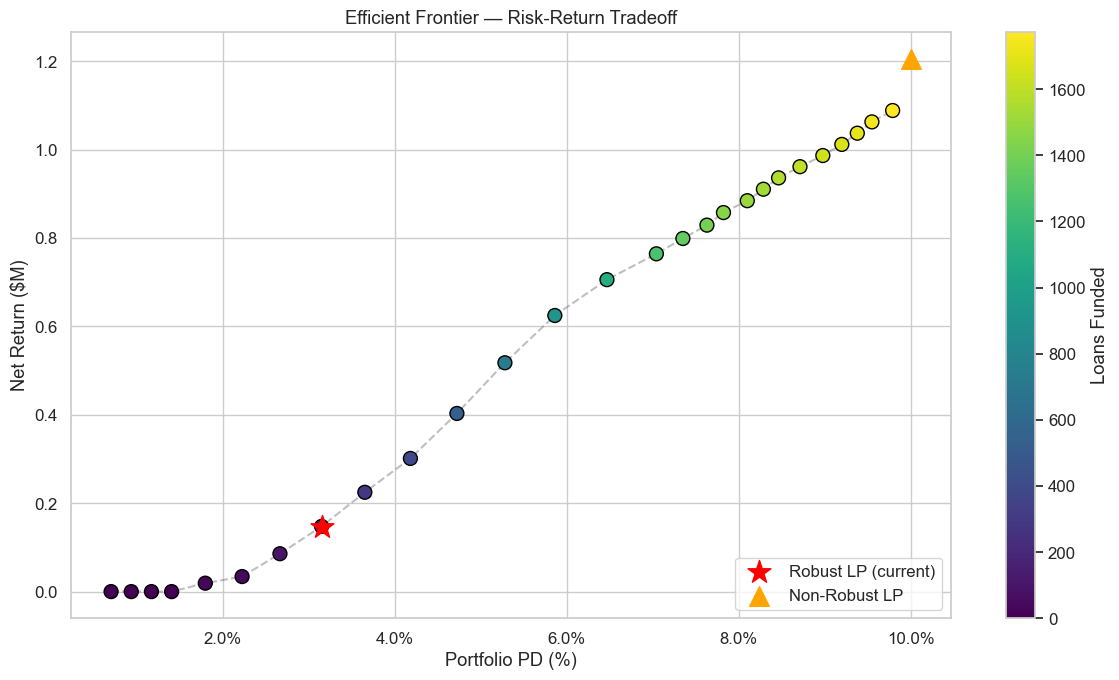

Efficient Frontier (selected points):
 pd_cap    return  risk_wpd  worst_loss  n_funded
 0.0300    0.0000    0.0070      0.0000         0
 0.0400    0.0000    0.0094      0.0000         0
 0.0500    0.0000    0.0117      0.0000         0
 0.0600    0.0000    0.0141      0.0000         0
 0.0700    19,038    0.0180      11,662        26
 0.0800    34,043    0.0223      24,558        40
 0.0900    85,735    0.0267      71,624        97
 0.1000   147,487    0.0315     138,500       176
 0.1100   224,759    0.0365     240,661       285
 0.1200   301,369    0.0418     350,946       382
 0.1300   403,138    0.0472     520,151       540
 0.1400   517,857    0.0528     730,931       737
 0.1500   624,816    0.0586     971,087       926
 0.1600   705,925    0.0647   1,205,945      1096
 0.1700   764,405    0.0704   1,427,485      1262
 0.1800   799,103    0.0735   1,566,050      1347
 0.1900   829,334    0.0763   1,693,385      1405
 0.2000   857,746    0.0782   1,814,981      1448
 0.2100   88

In [11]:
# Build efficient frontier by varying PD cap
frontier_caps = np.arange(0.03, 0.30, 0.01)
frontier = []

for cap in frontier_caps:
    try:
        model = build_portfolio_model(
            loans_df, pd_point, pd_low, pd_high, lgd, int_rates,
            total_budget=BUDGET, max_concentration=0.5,  # Relaxed for frontier
            max_portfolio_pd=cap, robust=True,
        )
        sol = solve_portfolio(model)
        alloc = np.array([sol['allocation'][i] for i in range(len(df_portfolio))])
        wpd = np.sum(alloc * loan_amounts * pd_point) / (np.sum(alloc * loan_amounts) + 1e-6)
        wc_loss = worst_case_expected_loss(alloc, loan_amounts, pd_high, lgd_point=lgd)

        frontier.append({
            "pd_cap": cap,
            "return": sol["objective_value"],
            "risk_wpd": wpd,
            "worst_loss": wc_loss,
            "n_funded": sol["n_funded"],
        })
    except Exception:
        pass

frontier_df = pd.DataFrame(frontier)

fig, ax = plt.subplots(figsize=(12, 7))

# Efficient frontier
sc = ax.scatter(frontier_df["risk_wpd"]*100, frontier_df["return"]/1e6,
                c=frontier_df["n_funded"], cmap="viridis", s=100, edgecolors="black", zorder=5)
ax.plot(frontier_df["risk_wpd"]*100, frontier_df["return"]/1e6, "--", color="gray", alpha=0.5)

# Mark current operating point
ax.scatter([wpd_robust*100], [sol_robust["objective_value"]/1e6],
           marker="*", s=300, color="red", zorder=10, label="Robust LP (current)")
ax.scatter([wpd_nonrobust*100], [sol_nonrobust["objective_value"]/1e6],
           marker="^", s=200, color="orange", zorder=10, label="Non-Robust LP")

plt.colorbar(sc, label="Loans Funded")
ax.set_xlabel("Portfolio PD (%)")
ax.set_ylabel("Net Return ($M)")
ax.set_title("Efficient Frontier — Risk-Return Tradeoff")
ax.legend(loc="lower right")
ax.xaxis.set_major_formatter(mticker.PercentFormatter(100))

plt.tight_layout()
plt.show()

print("Efficient Frontier (selected points):")
print(frontier_df.to_string(index=False, float_format=lambda x: f"{x:.4f}" if abs(x) < 1 else f"{x:,.0f}"))

---
## 10. Value of Conformal Prediction for Optimization

Quantify the **value of uncertainty information** from conformal prediction:
- How much does the robust solution differ from non-robust?
- What is the **price of robustness** (return given up for safety)?
- How often would the non-robust portfolio violate PD constraints under worst-case PDs?

In [12]:
# Price of robustness
price_of_robustness = sol_nonrobust["objective_value"] - sol_robust["objective_value"]
price_pct = price_of_robustness / sol_nonrobust["objective_value"] * 100 if sol_nonrobust["objective_value"] > 0 else 0

# Constraint violation analysis
# Under worst-case PDs, does the non-robust portfolio violate the PD constraint?
wpd_nonrobust_worst = np.sum(alloc_nonrobust * loan_amounts * pd_high) / (np.sum(alloc_nonrobust * loan_amounts) + 1e-6)
wpd_robust_worst = np.sum(alloc_robust * loan_amounts * pd_high) / (np.sum(alloc_robust * loan_amounts) + 1e-6)

print("Value of Conformal Prediction for Optimization:")
print(f"{'='*60}")
print(f"  Price of robustness: ${price_of_robustness:,.0f} ({price_pct:.1f}% of non-robust return)")
print(f"  This is the return given up for worst-case safety.")
print(f"")
print(f"  Under worst-case PDs (conformal upper bounds):")
print(f"    Non-robust portfolio PD: {wpd_nonrobust_worst:.4f} ({wpd_nonrobust_worst*100:.2f}%)")
print(f"    Robust portfolio PD:     {wpd_robust_worst:.4f} ({wpd_robust_worst*100:.2f}%)")
print(f"    PD constraint (max):     {MAX_PD:.4f} ({MAX_PD*100:.2f}%)")
print(f"")
if wpd_nonrobust_worst > MAX_PD:
    print(f"  ⚠ Non-robust VIOLATES PD constraint under worst case!")
    print(f"  ⚠ Violation: {(wpd_nonrobust_worst - MAX_PD)*100:.2f}pp over limit")
else:
    print(f"  Non-robust stays within PD constraint even under worst case.")
if wpd_robust_worst <= MAX_PD:
    print(f"  Robust portfolio satisfies PD constraint under worst case.")

# ECL comparison
ecl_robust_expected = worst_case_expected_loss(alloc_robust, loan_amounts, pd_point, lgd_point=lgd)
ecl_robust_worst = worst_case_expected_loss(alloc_robust, loan_amounts, pd_high, lgd_point=lgd)
ecl_nonrobust_expected = worst_case_expected_loss(alloc_nonrobust, loan_amounts, pd_point, lgd_point=lgd)
ecl_nonrobust_worst = worst_case_expected_loss(alloc_nonrobust, loan_amounts, pd_high, lgd_point=lgd)

print(f"\n  ECL Comparison:")
print(f"    {'':>25} {'Expected':>15} {'Worst Case':>15}")
print(f"    {'Robust':>25} ${ecl_robust_expected:>14,.0f} ${ecl_robust_worst:>14,.0f}")
print(f"    {'Non-Robust':>25} ${ecl_nonrobust_expected:>14,.0f} ${ecl_nonrobust_worst:>14,.0f}")

Value of Conformal Prediction for Optimization:
  Price of robustness: $1,060,278 (87.9% of non-robust return)
  This is the return given up for worst-case safety.

  Under worst-case PDs (conformal upper bounds):
    Non-robust portfolio PD: 0.4251 (42.51%)
    Robust portfolio PD:     0.1000 (10.00%)
    PD constraint (max):     0.1000 (10.00%)

  ⚠ Non-robust VIOLATES PD constraint under worst case!
  ⚠ Violation: 32.51pp over limit
  Robust portfolio satisfies PD constraint under worst case.

  ECL Comparison:
                                     Expected      Worst Case
                       Robust $        43,646 $       138,500
                   Non-Robust $     1,212,269 $     5,153,357


### Operational Conclusion for NB08
- This notebook translates statistical uncertainty into decision constraints (predict-then-optimize).
- The key result is not only expected return, but resilience under `PD_high` and constraint validity under stress.
- Practical value depends critically on conformal interval efficiency (coverage plus width).

---
## 11. Summary & Save Artifacts

### Key Findings

1. **Robust optimization with conformal intervals** produces safer portfolios at a modest return cost
2. **LP vs MILP**: MILP (binary) is more realistic; LP (continuous) gives an upper bound on achievable return
3. **Efficient frontier**: Clear risk-return tradeoff; tighter PD constraints reduce return but improve safety
4. **Price of robustness**: The return sacrifice for worst-case safety (quantified above)
5. **ECL minimization**: Alternative objective aligned with IFRS 9 regulatory requirements
6. **Value of CP**: Non-robust portfolios may violate PD constraints under worst-case scenarios

### Thesis Contribution
This notebook demonstrates the complete **Conformal Predict-then-Optimize** pipeline:
```
CatBoost PD → MAPIE Conformal [PD_low, PD_high] → Box Uncertainty → Pyomo LP/MILP → HiGHS → Optimal Portfolio
```
The conformal prediction intervals provide **distribution-free, finite-sample coverage guarantees**
that translate into **probabilistic guarantees on the optimization solution**.

### Connection to Other Notebooks
- **NB03 (PD)**: Point PD estimates → expected return/loss
- **NB04 (Conformal)**: PD intervals → uncertainty sets for robust optimization
- **NB06 (Survival)**: Lifetime PD → ECL term structure
- **NB07 (Causal)**: CATE → rate optimization potential
- **NB09 (Pipeline)**: Full end-to-end integration

In [13]:
# Save portfolio optimization results
portfolio_results = {
    "robust": {
        "objective": sol_robust["objective_value"],
        "n_funded": sol_robust["n_funded"],
        "allocated": sol_robust["total_allocated"],
        "portfolio_pd": float(wpd_robust),
    },
    "nonrobust": {
        "objective": sol_nonrobust["objective_value"],
        "n_funded": sol_nonrobust["n_funded"],
        "allocated": sol_nonrobust["total_allocated"],
        "portfolio_pd": float(wpd_nonrobust),
    },
    "milp": {
        "objective": sol_milp["objective_value"],
        "n_funded": sol_milp["n_funded"],
        "allocated": sol_milp["total_allocated"],
    },
    "ecl_minimized": {
        "ecl": float(ecl_value),
        "return": float(ecl_return),
        "n_funded": n_funded_ecl,
    },
    "price_of_robustness": float(price_of_robustness),
    "price_of_robustness_pct": float(price_pct),
    "budget": BUDGET,
    "max_pd": MAX_PD,
    "portfolio_size": len(df_portfolio),
}

with open(MODEL_DIR / "portfolio_results.pkl", "wb") as f:
    pickle.dump(portfolio_results, f)

# Save efficient frontier
frontier_df.to_parquet(DATA_DIR / "efficient_frontier.parquet")

# Save allocation
alloc_df = pd.DataFrame({
    "loan_idx": range(len(df_portfolio)),
    "alloc_robust": alloc_robust,
    "alloc_nonrobust": alloc_nonrobust,
    "alloc_milp": alloc_milp,
    "alloc_ecl": alloc_ecl,
    "pd_point": pd_point,
    "pd_low": pd_low,
    "pd_high": pd_high,
    "loan_amnt": loan_amounts,
    "int_rate": int_rates,
    "grade": grades,
})
alloc_df.to_parquet(DATA_DIR / "portfolio_allocations.parquet")

print("Artifacts saved:")
print(f"  Portfolio results: {MODEL_DIR / 'portfolio_results.pkl'}")
print(f"  Efficient frontier: {DATA_DIR / 'efficient_frontier.parquet'}")
print(f"  Allocations: {DATA_DIR / 'portfolio_allocations.parquet'}")
print(f"\nNB08 Portfolio Optimization complete!")

Artifacts saved:
  Portfolio results: ..\models\portfolio_results.pkl
  Efficient frontier: ..\data\processed\efficient_frontier.parquet
  Allocations: ..\data\processed\portfolio_allocations.parquet

NB08 Portfolio Optimization complete!


## Final Conclusions: Portfolio Optimization

### Key Findings
- Robust optimization protects against adverse PD realizations but can materially reduce return and deployment.
- Non-robust solutions can over-allocate risk when uncertainty is ignored.
- Feasibility and performance are highly sensitive to uncertainty-set quality.

### Financial Risk Interpretation
- The "price of robustness" is a direct economic measure of model uncertainty cost.
- Overly conservative uncertainty sets can produce capital under-deployment.
- Practical risk management requires balancing constraint safety and business throughput.

### Contribution to End-to-End Pipeline
- Converts model outputs into actionable allocation decisions under explicit constraints.
- Demonstrates the operational impact of conformal uncertainty on lending strategy.
- Closes the loop between predictive analytics and capital allocation policy.